In [18]:
import gymnasium as gym
import torch
from torch.autograd import Variable
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque

In [19]:
class DQN():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
        torch.nn.Linear(n_state, n_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hidden, n_action)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, s, y):
        # s: состояние
        # y: целевое значение
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, s):
        #      s: входное состояние
        # return: значения Q для всех действий
        with torch.no_grad():
            return self.model(torch.Tensor(s))
        
    def replay(self, memory, replay_size, gamma):
        """
        Воспроизведение опыта
        @param memory: буфер воспроизведения опыта
        @param replay_size: сколько примеров использовать при каждом
        обновлении модели
        @param gamma: коэффициент обесценивания
        """
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size)
            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()
                td_targets.append(q_values)
        
            self.update(states, td_targets)

In [20]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        else:
            q_values = estimator.predict(state)
        return torch.argmax(q_values).item()
    return policy_function

In [21]:
def q_learning(env, estimator, n_action, n_episode, total_reward_episode, memory, replay_size, gamma=1.0, epsilon=0.1, epsilon_decay=.99):
    """
    Глубокое Q-обучение с применением DQN
    @param env: имя окружающей среды Gym
    @param estimator: объект класса Estimator
    @param n_episode: количество эпизодов
    @param gamma: коэффициент обесценивания
    @param epsilon: параметр ε-жадной стратегии
    @param epsilon_decay: коэффициент затухания epsilon
    """
    for episode in tqdm(range(n_episode)):
        policy = gen_epsilon_greedy_policy(estimator, epsilon, n_action)
        state = env.reset()[0]
        is_done = False
        is_break = False
        while not is_done and not is_break:
            action = policy(state)
            next_state, reward, is_done, is_break, _ = env.step(action)
            total_reward_episode[episode] += reward
            modified_reward = next_state[0] + 0.5
            if next_state[0] >= 0.5:
                modified_reward += 100
            elif next_state[0] >= 0.25:
                modified_reward += 20
            elif next_state[0] >= 0.1:
                modified_reward += 10
            elif next_state[0] >= 0:
                modified_reward += 5
            
            memory.append((state, action, next_state, modified_reward, is_done))
            if is_done or is_break:
                break
            
            estimator.replay(memory, replay_size, gamma)
            state = next_state
        
        #print('Эпизод: {}, полное вознаграждение: {}, epsilon:{}'.format(episode,total_reward_episode[episode], epsilon))
        epsilon = max(epsilon * epsilon_decay, 0.01)


In [22]:
env = gym.envs.make("MountainCar-v0")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 50
lr = 0.001
memory = deque(maxlen=10000)
dqn = DQN(n_state, n_action, n_hidden, lr)

In [23]:
n_episode = 600
replay_size = 20
total_reward_episode = [0] * n_episode
q_learning(env, dqn, n_action, n_episode, total_reward_episode, memory, replay_size, gamma=.99, epsilon=.3)

100%|██████████| 600/600 [06:51<00:00,  1.46it/s]


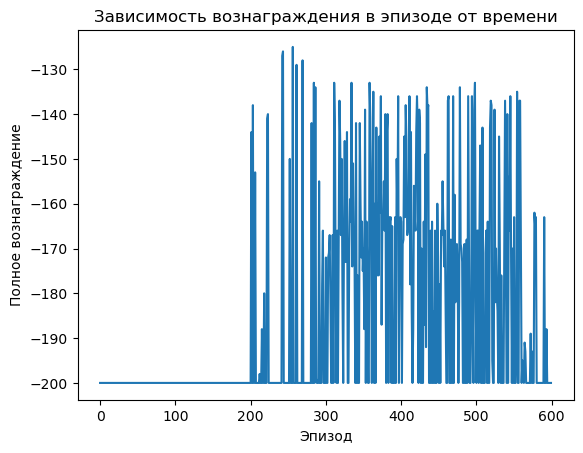

In [24]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

In [25]:
torch.save(dqn, 'mountain_car_v0_dqn_buffer.pth')